# 1. Buoyancy Frequency Profile

To be in accordance with TEOS-10 it translates from Salinity_[psu] & Temp_[°C] into Absolute_Salinity [g/kg] & Conservative_Temp_deg [°C]. As sources I used the TEOS-10 book, some ChatGPT, lots of StackOverflow or Python Library Documentations (which I can easily quote), and also Work/Study coding experience for which giving sources like "my own memory" isnt feasible.

Precise explanations to be found in the code

## Density Calculation

In [34]:
from pathlib import Path
import numpy as np
import pandas as pd
import gsw

# Paths
UDASH_FILE = Path("UDASH/ArcticOcean_phys_oce_2010.txt")
OUTPUT_DIR = Path("Density")
MISSING_VALUE = -999.0

# Finding the year within the txt
def _infer_year_from_timestamp(series: pd.Series) -> str:
    """Try to infer a year from the yyyy-mm-ddThh:mm column."""
    s = series.dropna().astype(str)
    if s.empty:
        return "unknown"
    first = s.iloc[0]
    try:
        return str(pd.to_datetime(first).year)
    except Exception:
        return str(first)[:4]

# Read raw UDASH file
def process_udash_file(path: Path, output_dir: Path = OUTPUT_DIR) -> tuple[pd.DataFrame, Path]:
    df = pd.read_csv(
        path,
        delim_whitespace=True,
        na_values=[MISSING_VALUE],
        engine="python",
    )

    # Replace explicit missing flag just in case
    df = df.replace(MISSING_VALUE, np.nan)

    # Make sure key columns exist
    required_cols = [
        "Prof_no",
        "Cruise",
        "Station",
        "Platform",
        "Type",
        "yyyy-mm-ddThh:mm",
        "Longitude_[deg]",
        "Latitude_[deg]",
        "Pressure_[dbar]",
        "Depth_[m]",
        "Temp_[°C]",
        "Salinity_[psu]",
    ]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns in UDASH file: {missing}")

    # Sort so casts stay together and levels are ordered
    sort_keys = [
        "Prof_no",
        "yyyy-mm-ddThh:mm",
        "Depth_[m]",
        "Pressure_[dbar]",
    ]
    sort_keys = [k for k in sort_keys if k in df.columns]
    df = df.sort_values(sort_keys).reset_index(drop=True)

    # TEOS-10 inputs
    SP = df["Salinity_[psu]"].to_numpy(float)
    t = df["Temp_[°C]"].to_numpy(float)
    p = df["Pressure_[dbar]"].to_numpy(float)
    lon = df["Longitude_[deg]"].to_numpy(float)
    lat = df["Latitude_[deg]"].to_numpy(float)

    # ChatGPT: Range-based masking
    def _mask_range(arr, lo, hi):
        bad = (arr < lo) | (arr > hi)
        arr = arr.copy()
        arr[bad] = np.nan
        return arr
    
    # ChatGPT: Range-based masking
    lat = _mask_range(lat, -90, 90)
    lon = _mask_range(lon, -180, 360)
    p = _mask_range(p, 0, 12000)
    SP = _mask_range(SP, 0, 50)
    t = _mask_range(t, -5, 40)

    # TEOS-10 computations
    SA = gsw.SA_from_SP(SP, p, lon, lat)           # Absolute salinity [g/kg]
    CT = gsw.CT_from_t(SA, t, p)                   # Conservative temperature [°C]
    rho = gsw.rho(SA, CT, p)                       # In-situ density [kg/m³]
    sigma0 = gsw.sigma0(SA, CT) + 1000.0           # Potential density σ0 + 1000

    # Attach TEOS-10 variables + source_file
    df = df.copy()
    df.insert(0, "source_file", path.name)
    df["Absolute_Salinity_g_kg"] = SA
    df["Conservative_Temp_degC"] = CT
    df["Density_kg_m3"] = rho
    df["Potential_Density_kg_m3"] = sigma0

    # Build output path with year tag
    year = _infer_year_from_timestamp(df["yyyy-mm-ddThh:mm"])
    output_dir.mkdir(parents=True, exist_ok=True)
    out_path = output_dir / f"{year}_{path.stem}_teos10.txt"

    # Choose column order for TEOS-10 file (I prefer to save more rather than less)
    out_cols = [
        "source_file",
        "Prof_no",
        "yyyy-mm-ddThh:mm",
        "Longitude_[deg]",
        "Latitude_[deg]",
        "Pressure_[dbar]",
        "Depth_[m]",
        "Temp_[°C]",
        "Salinity_[psu]",
        "Absolute_Salinity_g_kg",
        "Conservative_Temp_degC",
        "Density_kg_m3",
        "Potential_Density_kg_m3",
    ]
    out_cols = [c for c in out_cols if c in df.columns]

    # Write nicely sorted TEOS-10 file
    df[out_cols].to_csv(
        out_path,
        sep="\t",
        index=False,
        float_format="%.6f",
    )

    print(f"Loaded {len(df)} rows from {path}")
    print(f"TEOS-10 file written to: {out_path}")
    return df, out_path


# EXECUTION
df_teos10, teos10_path = process_udash_file(UDASH_FILE)

# Show a quick preview
df_teos10.head()

/tmp/ipykernel_28586/2968834839.py:25: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


Loaded 4222752 rows from UDASH/ArcticOcean_phys_oce_2010.txt
TEOS-10 file written to: Density/2010_ArcticOcean_phys_oce_2010_teos10.txt


,source_file,Prof_no,Cruise,Station,Platform,Type,yyyy-mm-ddThh:mm,Longitude_[deg],Latitude_[deg],Pressure_[dbar],...,Salinity_[psu],QF.2,Source,DOI,WOD-Cruise-ID,WOD-Cast-ID,Absolute_Salinity_g_kg,Conservative_Temp_degC,Density_kg_m3,Potential_Density_kg_m3
0,ArcticOcean_phys_oce_2010.txt,12202,JOHAN_HJORT,0023,S,CTD,2010-01-24T01:34,12.2835,69.0342,5.0,...,35.2074,0,ices,NaN,NaN,NaN,35.374720,7.293950,1027.563862,1027.541038
1,ArcticOcean_phys_oce_2010.txt,12202,JOHAN_HJORT,0023,S,CTD,2010-01-24T01:34,12.2835,69.0342,6.0,...,35.2075,0,ices,NaN,NaN,NaN,35.374825,7.293853,1027.568522,1027.541134
2,ArcticOcean_phys_oce_2010.txt,12202,JOHAN_HJORT,0023,S,CTD,2010-01-24T01:34,12.2835,69.0342,7.0,...,35.2077,0,ices,NaN,NaN,NaN,35.375031,7.293755,1027.573261,1027.541308
3,ArcticOcean_phys_oce_2010.txt,12202,JOHAN_HJORT,0023,S,CTD,2010-01-24T01:34,12.2835,69.0342,8.0,...,35.2076,0,ices,NaN,NaN,NaN,35.374935,7.294660,1027.577620,1027.541104
4,ArcticOcean_phys_oce_2010.txt,12202,JOHAN_HJORT,0023,S,CTD,2010-01-24T01:34,12.2835,69.0342,9.0,...,35.2079,0,ices,NaN,NaN,NaN,35.375241,7.293562,1027.582581,1027.541500


## Buoyancy Calculation

From the just calculated density I here now calculate the buoyancy profile for all the casts in a given year.


In [36]:
from pathlib import Path
import numpy as np
import pandas as pd
import gsw

# Define tunable QC thresholds for the quality control parameter that will be introduced later
MIN_DEPTH_RANGE_OK = 200.0   # [m] minimum depth range to be "acceptable"
MIN_DEPTH_RANGE_GOOD = 400.0 # [m] minimum depth range to be "good"
MAX_GAP_GOOD = 50.0          # [m] maximum vertical gap to still call it "good"

# Path
UDASH_FILE = Path("UDASH/ArcticOcean_phys_oce_2010.txt")
TEOS_DIR = Path("Density")
N2_DIR = Path("N2")

# CHATGPT: Find the TEOS-10 file produced earlier (For some reason I can never grasp how to retrieve paths...)
pattern = f"*_{UDASH_FILE.stem}_teos10.txt"
teos_files = sorted(TEOS_DIR.glob(pattern))
if not teos_files:
    raise FileNotFoundError(f"No TEOS-10 file matching {pattern} in {TEOS_DIR}")
TEOS10_FILE = teos_files[0]

# Load TEOS-10 data
df = pd.read_csv(TEOS10_FILE, sep="\t")

def compute_N2_for_cast(g: pd.DataFrame) -> pd.DataFrame | None:
    """
    Compute N2 for a single cast, keeping metadata and QC (quality control parameters).

    QC includes:
      - Chelton style overwriting of negative N2
      - Depth range of the profile
      - Maximum vertical gap introduction for the gridding
      - Quality flag N2_QC_flag:
          0 = poor (too shallow / very gappy (as defined from the QC thresholds))
          1 = acceptable (depth range >= MIN_DEPTH_RANGE_OK)
          2 = good (depth range >= MIN_DEPTH_RANGE_GOOD and max gap <= MAX_GAP_GOOD)
    """
    g = g.sort_values("Pressure_[dbar]").dropna(
        subset=["Absolute_Salinity_g_kg", "Conservative_Temp_degC",
                "Density_kg_m3", "Pressure_[dbar]", "Latitude_[deg]"]
    )
    if len(g) < 3:
        return None

    # gsw only takes floating point numbers
    SA = g["Absolute_Salinity_g_kg"].to_numpy(float)
    CT = g["Conservative_Temp_degC"].to_numpy(float)
    p = g["Pressure_[dbar]"].to_numpy(float)
    rho = g["Density_kg_m3"].to_numpy(float)
    lat = float(g["Latitude_[deg]"].iloc[0])

    # N2 and mid-pressure as gsw is defined (as in Pinner et al 2025)
    N2_raw, p_mid = gsw.Nsquared(SA, CT, p, lat)
    if N2_raw.size == 0:
        return None

    # as in Chelton et al 1998
    # negative N2(z_k) → N2(z_{k-1}); if shallowest N2(z_1) < 0 → 1e-8
    N2_fixed = N2_raw.copy()
    for k in range(len(N2_fixed)):
        if N2_fixed[k] < 0:
            if k == 0:
                N2_fixed[k] = 1e-8  # s^-2 at shallowest level
            else:
                N2_fixed[k] = N2_fixed[k - 1]
    N2 = N2_fixed

    # depth and mid-point variables (as in Pinner et al 2025) because gsw uses midpoint depths
    z_mid = -gsw.z_from_p(p_mid, lat)  # positive depth
    SA_mid = 0.5 * (SA[:-1] + SA[1:])
    CT_mid = 0.5 * (CT[:-1] + CT[1:])
    rho_mid = 0.5 * (rho[:-1] + rho[1:])

    # QC metrics: depth range, max vertical gap, number of levels
    # What makes a good quality result? The positive definitiveness of N2 is already ensured. For plotting purposes it is benefitial
    # have data in regular, reasnable distances which are somewhat evenly spaced, dont vary too much in amount of levels between
    # individual casts. The spatial (lat-lon) relation shall not be considered here, as we want to have variation in that realm. 
    # Large values of N2 shall further not be incorporated either, as they might highlight patterns or measurement errors.
    if z_mid.size > 0:
        depth_range = float(z_mid.max() - z_mid.min())
    else:
        depth_range = 0.0

    if z_mid.size > 1:
        dz = np.diff(z_mid)
        max_gap = float(np.max(dz))
    else:
        dz = np.array([])
        max_gap = np.nan

    n_levels = int(z_mid.size)

    # Quality flag
    # 0 = poor, 1 = acceptable, 2 = good
    qc_flag = 0
    if depth_range >= MIN_DEPTH_RANGE_OK:
        qc_flag = 1
    if (depth_range >= MIN_DEPTH_RANGE_GOOD) and np.isfinite(max_gap) and (max_gap <= MAX_GAP_GOOD):
        qc_flag = 2

    # construct columns again
    first = g.iloc[0]
    return pd.DataFrame({
        "source_file": first["source_file"],
        "Prof_no": first["Prof_no"],
        "yyyy-mm-ddThh:mm": first["yyyy-mm-ddThh:mm"],
        "Longitude_[deg]": first["Longitude_[deg]"],
        "Latitude_[deg]": first["Latitude_[deg]"],
        "Pressure_[dbar]": p_mid,
        "Depth_[m]": z_mid,
        "Absolute_Salinity_[g/kg]": SA_mid,
        "Conservative_Temperature_[°C]": CT_mid,
        "In-situ_Density_[kg m^-3]": rho_mid,
        "N2_[s^-2]": N2,
        # QC columns repeated for all rows per cast (easier than to create additional file per cast or to build hashmaps)
        "Depth_range_[m]": depth_range,
        "Max_gap_[m]": max_gap,
        "N_levels": n_levels,
        "N2_QC_flag": qc_flag,
    })

# Compute N2 for all casts (For-Loop Friederike mentioned in her mail, though I feel like it is easier to include it from the start)
pieces = []
for pid, gcast in df.groupby("Prof_no"):
    out = compute_N2_for_cast(gcast)
    if out is not None:
        pieces.append(out)

# Error message so as not to just get a Python error
if not pieces:
    raise RuntimeError("No valid casts for N² computation.")

dfN2 = pd.concat(pieces, ignore_index=True)

# Ensure sorting: by profile, then depth, then pressure
dfN2 = dfN2.sort_values(
    ["Prof_no", "Depth_[m]", "Pressure_[dbar]"]
).reset_index(drop=True)

# CHATGPT: Build output path and save
N2_DIR.mkdir(parents=True, exist_ok=True)
year_tag = TEOS10_FILE.stem.split("_", 1)[0]  # e.g. "1980"
out_path = N2_DIR / f"N2_{year_tag}_{UDASH_FILE.stem}.txt"

cols_out = [
    "source_file",
    "Prof_no",
    "yyyy-mm-ddThh:mm",
    "Longitude_[deg]",
    "Latitude_[deg]",
    "Pressure_[dbar]",
    "Depth_[m]",
    "Absolute_Salinity_[g/kg]",
    "Conservative_Temperature_[°C]",
    "In-situ_Density_[kg m^-3]",
    "N2_[s^-2]",
    "Depth_range_[m]",
    "Max_gap_[m]",
    "N_levels",
    "N2_QC_flag",
]
cols_out = [c for c in cols_out if c in dfN2.columns]

# CHATGPT: saves the DataFrame as a tab-separated text file
dfN2[cols_out].to_csv(
    out_path,
    sep="\t",
    index=False,
    float_format="%.6e",
)

print(f"Computed N² for {dfN2['Prof_no'].nunique()} casts "
      f"({len(dfN2)} midpoints).")
print(f"N² file written to: {out_path}")

dfN2.head()


Computed N² for 8607 casts (4199007 midpoints).
N² file written to: N2/N2_2010_ArcticOcean_phys_oce_2010.txt


,source_file,Prof_no,yyyy-mm-ddThh:mm,Longitude_[deg],Latitude_[deg],Pressure_[dbar],Depth_[m],Absolute_Salinity_[g/kg],Conservative_Temperature_[°C],In-situ_Density_[kg m^-3],N2_[s^-2],Depth_range_[m],Max_gap_[m],N_levels,N2_QC_flag
0,ArcticOcean_phys_oce_2010.txt,12202,2010-01-24T01:34,12.2835,69.0342,5.5,5.444562,35.374773,7.293902,1027.566192,9.259791e-07,1478.553034,0.994714,1500,2
1,ArcticOcean_phys_oce_2010.txt,12202,2010-01-24T01:34,12.2835,69.0342,6.5,6.434467,35.374928,7.293804,1027.570892,1.689016e-06,1478.553034,0.994714,1500,2
2,ArcticOcean_phys_oce_2010.txt,12202,2010-01-24T01:34,12.2835,69.0342,7.5,7.424367,35.374983,7.294208,1027.575441,1.689016e-06,1478.553034,0.994714,1500,2
3,ArcticOcean_phys_oce_2010.txt,12202,2010-01-24T01:34,12.2835,69.0342,8.5,8.414262,35.375088,7.294111,1027.580100,3.827017e-06,1478.553034,0.994714,1500,2
4,ArcticOcean_phys_oce_2010.txt,12202,2010-01-24T01:34,12.2835,69.0342,9.5,9.404152,35.375043,7.293517,1027.584714,3.827017e-06,1478.553034,0.994714,1500,2


# Buoyancy Example Cast

Lets just plot one individual cast to make sure the resulting Buoyancy Profile appears physically reasonable.
That plotting cell is not Step 3.
It only reads the native N2 profile and visualizes it, does no interpolation to a regular vertical grid and doesn’t change the data.

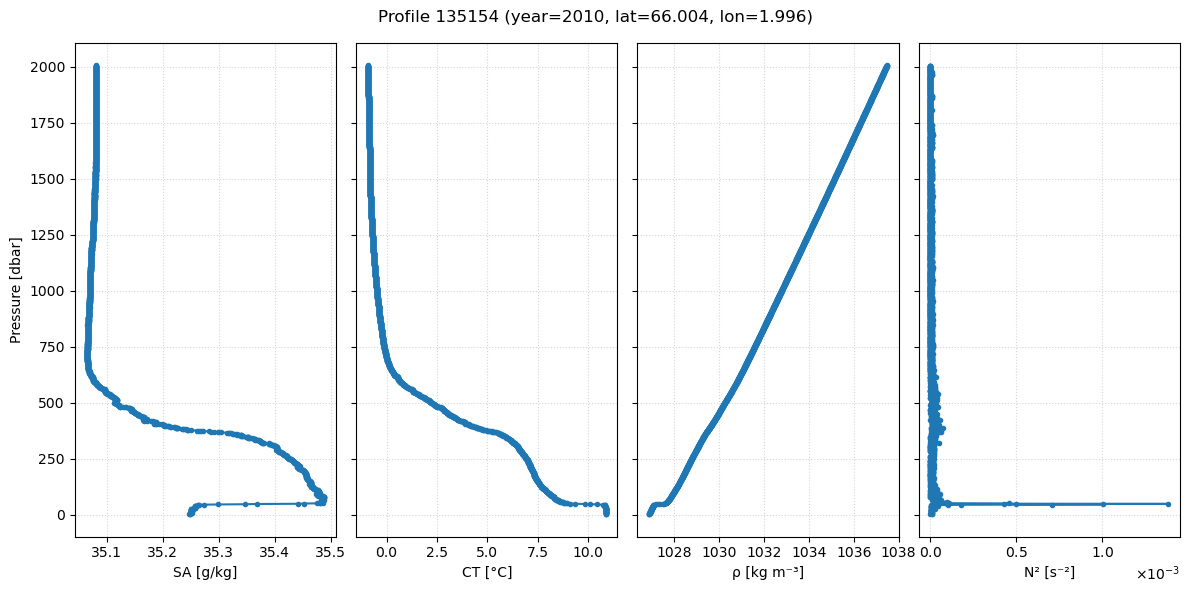

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter
from pathlib import Path


year = 2010            
profile_id = 135154       

# Load UDASH file for that year
UDASH_FILE = Path(f"UDASH/ArcticOcean_phys_oce_{year}.txt")
TEOS_DIR = Path("Density")

# CHATGPT: ensures you get the correct TEOS-10 file associated with the UDASH file by searching for a pattern
pattern_teos = f"*_{UDASH_FILE.stem}_teos10.txt"
teos_files = sorted(TEOS_DIR.glob(pattern_teos))
if not teos_files:
    raise FileNotFoundError(f"No TEOS-10 file matching {pattern_teos}")

TEOS10_FILE = teos_files[0]
df_teos10 = pd.read_csv(TEOS10_FILE, sep="\t")

# CHATGPT: Load N2 file for that year the same way like the TEOS-10 file
N2_DIR = Path("N2")
n2_file = N2_DIR / f"N2_{year}_{UDASH_FILE.stem}.txt"
if not n2_file.exists():
    raise FileNotFoundError(f"N2 file not found: {n2_file}")

dfN2 = pd.read_csv(n2_file, sep="\t")

# Select the chosen cast from both files
g_teos = (
    df_teos10[df_teos10["Prof_no"] == profile_id]
    .sort_values("Pressure_[dbar]")
)

g_n2 = (
    dfN2[dfN2["Prof_no"] == profile_id]
    .sort_values("Pressure_[dbar]")
)

# Give a warning if one file doesnt have that cast
if g_teos.empty:
    raise RuntimeError(f"Cast {profile_id} not found in TEOS-10 file for year {year}")

if g_n2.empty:
    raise RuntimeError(f"Cast {profile_id} not found in N2 file for year {year}")

# Extract variables and make them into float agsin
p = g_teos["Pressure_[dbar]"].to_numpy()
SA = g_teos["Absolute_Salinity_g_kg"].to_numpy()
CT = g_teos["Conservative_Temp_degC"].to_numpy()
rho = g_teos["Density_kg_m3"].to_numpy()

p_mid = g_n2["Pressure_[dbar]"].to_numpy()
N2v = g_n2["N2_[s^-2]"].to_numpy()

# Plot
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey=True)

axes[0].plot(SA, p, marker=".")
axes[0].set_xlabel("SA [g/kg]")
axes[0].set_ylabel("Pressure [dbar]")

axes[1].plot(CT, p, marker=".")
axes[1].set_xlabel("CT [°C]")

axes[2].plot(rho, p, marker=".")
axes[2].set_xlabel("ρ [kg m⁻³]")

axes[3].plot(N2v, p_mid, marker=".")
axes[3].set_xlabel("N² [s⁻²]")

# I prefer scientific notation for the buoyancy frequencies
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
axes[3].xaxis.set_major_formatter(formatter)
axes[3].ticklabel_format(style="sci", axis="x", scilimits=(0, 3))

# Inverts the axis because pressure and depth are inversely related
for ax in axes:
    ax.invert_yaxis()
    ax.grid(True, linestyle=":", alpha=0.5)

# Lat & Lon of the FIRST measurement per cast
lat = g_teos["Latitude_[deg]"].iloc[0]
lon = g_teos["Longitude_[deg]"].iloc[0]

fig.suptitle(
    f"Profile {profile_id} (year={year}, lat={lat:.3f}, lon={lon:.3f})",
    y=0.98
)

plt.tight_layout()
plt.show()


For one cast (one Prof_no) this code takes the mid-point depths and N2 from dfN2 (Depth_[m], N2_[s^-2] for that Prof_no and year), then does a check to only proceed if N2_QC_flag is at least 1 or 2.

Afterwards I define a regular depth grid (e.g. Δz = 5–10 m or the median native Δz) which I can simply adapt on the go.

Finally to interpolate N²(z) from the irregular z_mid to the regular z_reg, so as not only to have the pressure plot as above.

Preparing cast Prof_no=135154 (year=2010) for EVP
  N2_QC_flag = 2, depth_range = 1971.8 m, max_gap = 1.0 m
  Regular grid: 1975 levels, dz ≈ 1.00 m
  Time: 2010-10-03 21:04:00  (month=10)


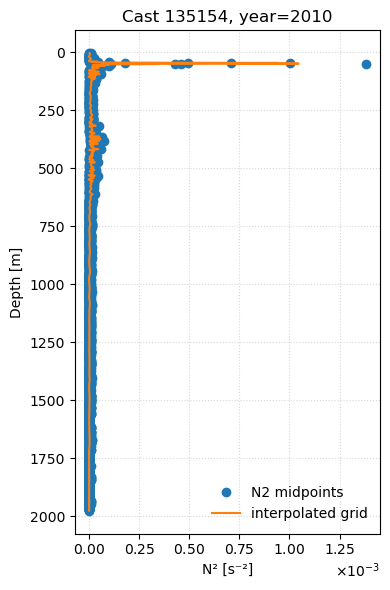

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.ticker import ScalarFormatter



year = 2010           # year of interest
profile_id = 135154      # Prof_no to prepare for EVP
dz_target = None      # if None -> use median native Δz; else set as one likes

# Load N2 file for that year
UDASH_FILE = Path(f"UDASH/ArcticOcean_phys_oce_{year}.txt")
N2_DIR = Path("N2")
n2_file = N2_DIR / f"N2_{year}_{UDASH_FILE.stem}.txt"

# Error if that file doesnt exit
if not n2_file.exists():
    raise FileNotFoundError(f"N2 file not found: {n2_file}")

dfN2 = pd.read_csv(n2_file, sep="\t")

# Cast out the non-casted casts to keep the casted cast
g = (
    dfN2[dfN2["Prof_no"] == profile_id]
    .sort_values("Depth_[m]")
    .dropna(subset=["Depth_[m]", "N2_[s^-2]"])
)

# Cast-check the cast table. If the casted cast is castless, cast a RuntimeError for the cast-year.
if g.empty:
    raise RuntimeError(f"Cast {profile_id} not found in N2 file for year {year}")

# QC info since it´s best to just ignore the 0´s
qc_flag = g["N2_QC_flag"].iloc[0] if "N2_QC_flag" in g.columns else np.nan
depth_range = g["Depth_range_[m]"].iloc[0] if "Depth_range_[m]" in g.columns else np.nan
max_gap = g["Max_gap_[m]"].iloc[0] if "Max_gap_[m]" in g.columns else np.nan

print(f"Preparing cast Prof_no={profile_id} (year={year}) for EVP")
print(f"  N2_QC_flag = {qc_flag}, depth_range = {depth_range:.1f} m, max_gap = {max_gap:.1f} m")

# Native mid-point depth and N2 to float
z_mid = g["Depth_[m]"].to_numpy(float)
N2_mid = g["N2_[s^-2]"].to_numpy(float)

# Ensure we have enough levels per cast to yield a physically meaningful profile
if z_mid.size < 3:
    raise RuntimeError("Too few N² levels to build a useful regular grid.")

# Define regular depth grid from the mid-depths as is intrinsic to Chelton and the gsw function
dz_native = np.diff(z_mid)
dz_med = float(np.median(dz_native)) if dz_native.size > 0 else np.nan

# Define substitution seperation
if dz_target is None:
    dz = dz_med
else:
    dz = float(dz_target)

if not np.isfinite(dz) or dz <= 0:
    raise RuntimeError(f"Could not determine a positive dz (dz_native_med = {dz_med})")

zmin, zmax = float(z_mid.min()), float(z_mid.max())
z_reg = np.arange(zmin, zmax + 0.5 * dz, dz)  # include top & bottom

# Interpolate N2 onto regular grid how I learned it
#N2_reg = np.interp(z_reg, z_mid, N2_mid)

# CHATGPT
# Interpolate N2 onto regular grid with a smooth spline
# s = 0 -> passes exactly through the data (already much smoother than np.interp)
# increase s for more smoothing, e.g. s=len(z_mid)*np.var(N2_mid)*0.1
from scipy.interpolate import UnivariateSpline
spline = UnivariateSpline(z_mid, N2_mid, s=0.00000005)
N2_reg = spline(z_reg)


# Grab metadata (lat, lon, time, month) from the first part of the cast
lat = float(g["Latitude_[deg]"].iloc[0])
lon = float(g["Longitude_[deg]"].iloc[0])

cast_time = None
cast_month = None
if "yyyy-mm-ddThh:mm" in g.columns:
    try:
        cast_time = pd.to_datetime(g["yyyy-mm-ddThh:mm"].iloc[0])
        cast_month = cast_time.month
    except Exception:
        pass

print(f"  Regular grid: {z_reg.size} levels, dz ≈ {dz:.2f} m")
if cast_month is not None:
    print(f"  Time: {cast_time}  (month={cast_month})")

# Quick diagnostic plot: pointwise vs interpolated N2
fig, ax = plt.subplots(figsize=(4, 6))

ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 2))

ax.plot(N2_mid, z_mid, "o", label="N2 midpoints")
ax.plot(N2_reg, z_reg, "-", label="interpolated grid")
ax.invert_yaxis()
ax.set_xlabel("N² [s⁻²]")
ax.set_ylabel("Depth [m]")
ax.grid(True, linestyle=":", alpha=0.5)
ax.legend(frameon=False)
ax.set_title(f"Cast {profile_id}, year={year}")

plt.tight_layout()
plt.show()

# z_reg and N2_reg are now ready for EVP (Step 4–5)


I am thinking that an uncertainty calculation is needed due to the error propagation. Perhaps the MAD-based Method found in the Git Repository of Pollmann et.al. can be adapted to this here?

It is furthermore worthwile to retrieve an overall profile for a given year, despite seasonal variations, just to make sure it overall behaves somewhat physical.

Year 2010: 5356 casts with N2_QC_flag >= 2
Included 5356 casts in the average profile.


/tmp/ipykernel_28586/533555326.py:74: RuntimeWarning: Mean of empty slice
  mean_N2 = np.nanmean(N2_stack, axis=0)
/home/conda/envs/ocean/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1216: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,


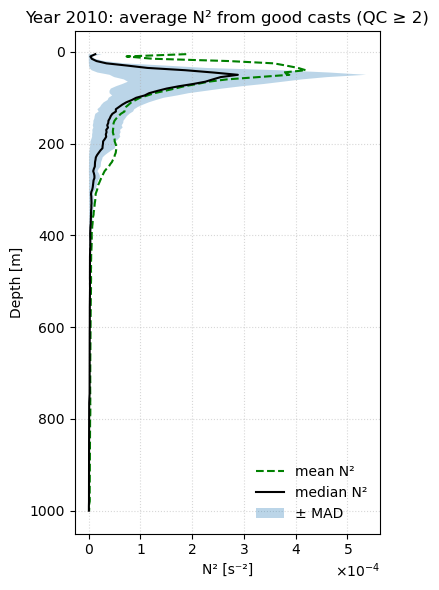

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.ticker import ScalarFormatter


# SETTINGS
year = 2010           # year to process
qc_min = 2            # minimum N2_QC_flag to accept
z_min = 0.0           # depth range for common grid [m]
z_max = 1000.0         # "
dz = 5.0              # grid spacing [m]

# Load N2 file for that year
UDASH_FILE = Path(f"UDASH/ArcticOcean_phys_oce_{year}.txt")
N2_DIR = Path("N2")
n2_file = N2_DIR / f"N2_{year}_{UDASH_FILE.stem}.txt"

if not n2_file.exists():
    raise FileNotFoundError(f"N2 file not found: {n2_file}")

dfN2 = pd.read_csv(n2_file, sep="\t")

# Select "good" casts by QC flag
if "N2_QC_flag" not in dfN2.columns:
    raise RuntimeError("Column 'N2_QC_flag' not found. "
                       "Make sure you ran the QC-aware N² cell.")

good = dfN2[dfN2["N2_QC_flag"] >= qc_min].copy()
if good.empty:
    raise RuntimeError(f"No casts with N2_QC_flag >= {qc_min} for year {year}.")

# Retain the approved cast id´s
cast_ids = good["Prof_no"].unique()
print(f"Year {year}: {len(cast_ids)} casts with N2_QC_flag >= {qc_min}")

# Build common depth grid at the midpoints
z_grid = np.arange(z_min, z_max + dz/2, dz)
nz = z_grid.size

# Matrix to hold N2(z) per cast on common grid
N2_stack = []

# Loop that checks each N2 wether it is in an approved cast and then turns it into float
for cid in cast_ids:
    g = (
        good[good["Prof_no"] == cid]
        .sort_values("Depth_[m]")
        .dropna(subset=["Depth_[m]", "N2_[s^-2]"])
    )
    if g.empty or g["Depth_[m]"].nunique() < 3:
        continue

    z_mid = g["Depth_[m]"].to_numpy(float)
    N2_mid = g["N2_[s^-2]"].to_numpy(float)

# interpolate to z_grid and set values outside native range to NaN
    z_lo, z_hi = z_mid.min(), z_mid.max()
    N2_interp = np.interp(z_grid, z_mid, N2_mid)
    mask_outside = (z_grid < z_lo) | (z_grid > z_hi)
    N2_interp[mask_outside] = np.nan

    N2_stack.append(N2_interp)

# We cant interpolate if there is nothing to interpolate
N2_stack = np.array(N2_stack)
if N2_stack.size == 0:
    raise RuntimeError("No valid casts for interpolation on common grid.")

print(f"Included {N2_stack.shape[0]} casts in the average profile.")

# Compute average profiles (mean, median, MAD) as in Pinner et al 2025
mean_N2 = np.nanmean(N2_stack, axis=0)
median_N2 = np.nanmedian(N2_stack, axis=0)
mad_N2 = np.nanmedian(np.abs(N2_stack - median_N2), axis=0)

# Plot average N2 profiles
fig, ax = plt.subplots(figsize=(4, 6))


ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 2))


ax.plot(mean_N2, z_grid, "g--", label="mean N²")
ax.plot(median_N2, z_grid, "k-", label="median N²")

# show MAD envelope
ax.fill_betweenx(
    z_grid,
    median_N2 - mad_N2,
    median_N2 + mad_N2,
    alpha=0.3,
    label="± MAD"
)

ax.invert_yaxis()
ax.set_xlabel("N² [s⁻²]")
ax.set_ylabel("Depth [m]")
ax.grid(True, linestyle=":", alpha=0.5)
ax.legend(frameon=False)
ax.set_title(f"Year {year}: average N² from good casts (QC ≥ {qc_min})")

plt.tight_layout()
plt.show()

# If you want to keep the average profile as a DataFrame:
#dfN2_avg = pd.DataFrame({
#    "Depth_[m]": z_grid,
#    "mean_N2_[s^-2]": mean_N2,
#    "median_N2_[s^-2]": median_N2,
#    "MAD_N2_[s^-2]": mad_N2,
#})


# 2. Creating the Eigenvalue Problem

This will need a few days of literature recherche and reading into, as we are now entering the not so well documented realms. PDF sources are stored locally again

Non PDF Sources:
- https://gist.github.com/douglatornell/5479638
- https://github.com/OceanLabPy/OceanLab/blob/master/examples/DYN_EOF.ipynb    (not this example, but maybe DYN.vmodes(...)
- https://github.com/UBC-MOAD/AIMS-Workshop/blob/main/dynmodes/dynmodes.ipynb   (is a newer refined version, could be changed to work)
- "Fast and Accurate Computation of Vertical Modes" Early et.al. 2020 could help too, since I literally have worked with spectral methods and Chebyshev Polynomials befor
- Chelton et.al. 1998 still is really helpful
- "The Vertical Mode Decomposition of Surface and Internal Tides in the Presence of a Free Surface and Arbitrary Topography" by Samuel L. Kelly 2016, although here I wonder if his assumptions even remotely agree with mine


Furthermore, the large errors and variations of the Buoyancy Frequency in the upper meters call for caution due to error propagation.

# 4. Mapping the results